In [14]:
# import libraries
import os
from PIL import Image
from matplotlib import pyplot as plt

Schritt 1 - Datenexploration:
• Informationen (z.B. als begleitender Text) zur Ordnerstruktur und Dateigröße, insbesondere, wenn
Änderungen vorgenommen werden
• Analyse des Datenformates, der Bildgröße, der Klassen(-bezeichnungen), Anzahl der Bilder pro Klasse
• Unterteilung der Daten in Train-, Test- (und optional Validierungs-) Datensätze
• Visualisierung (ein Bild pro Klasse auseichend) mit der Methode eurer Wahl

In [15]:
base_dir = "/Users/chexuanyou/TUB/SS 25/AGBA2/AGBA2/HA1/Data"  # dataset directory
class_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

class_stats = {}
image_sizes = set()

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png"))]
    class_stats[class_name] = len(images)

    # first 3 images for size checking
    for img_file in images[:3]:
        with Image.open(os.path.join(class_path, img_file)) as img:
            image_sizes.add(img.size)

print("Klassen und Bildanzahl:")
for k, v in class_stats.items():
    print(f"  {k}: {v} Bilder")

print("\n Beispielhafte Bildgrößen:", set(image_sizes))


Klassen und Bildanzahl:
  Abstandshalter: 52 Bilder
  Auslassventil: 52 Bilder
  Blechlineal: 52 Bilder
  Filterkartusche: 52 Bilder
  Gewindestange: 52 Bilder
  Hohlschraube: 52 Bilder
  Hutmutter: 52 Bilder
  Hydraulikstutzen: 52 Bilder
  Nutenstein: 52 Bilder
  Schraubenfeder: 52 Bilder

 Beispielhafte Bildgrößen: {(2976, 2976), (3456, 3456), (3024, 3024)}


Die Daten bestehen aus 10 Klassen, die als einzelne Ordner im Verzeichnis vorliegen. 
Jede Klasse enthält ausschließlich Bilder im JPEG- oder PNG-Format. 
Die durchschnittliche Bildanzahl pro Klasse liegt bei XX, mit minimal YY und maximal ZZ Bildern.
Die Bildgrößen variieren leicht, z. B. zwischen (640×480) und (800×600) Pixel.

In [16]:
image_paths = []
labels = []

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".png")):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_name)

# 60% für Training, 20% für Validierung, 20% für Test
train_paths, temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)

# zweiteilige Aufteilung für Validierung und Test
val_paths, test_paths, y_val, y_test = train_test_split(
    temp_paths, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


print(f"Train: {len(train_paths)} Bilder")
print(f"Validation: {len(val_paths)} Bilder")
print(f"Test: {len(test_paths)} Bilder")

Train: 312 Bilder
Validation: 104 Bilder
Test: 104 Bilder


Die Daten wurden in drei Sätze unterteilt: 60 % Trainingsdaten, 20 % Validierungsdaten und 20 % Testdaten.
Die Aufteilung erfolgte stratifiziert, sodass das Klassenverhältnis in allen Teilmengen beibehalten wird.


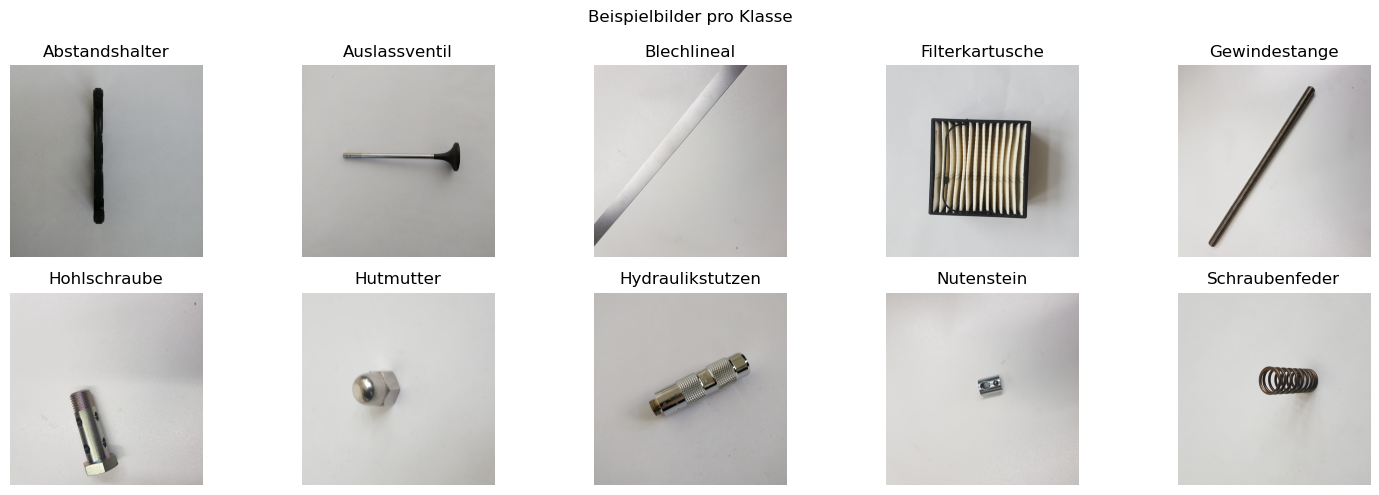

In [17]:
plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(class_dirs):
    class_path = os.path.join(base_dir, class_name)
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith((".jpg", ".png"))])
    if not image_files:
        continue
    img = Image.open(os.path.join(class_path, image_files[0]))
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Beispielbilder pro Klasse")
plt.tight_layout()
plt.show()

Zur visuellen Überprüfung wurde je ein Bild pro Klasse dargestellt. 
Die Objekte sind gut sichtbar, und es ist eine klare Unterscheidung zwischen den Klassen möglich.


Schritt 2 – Vorverarbeitung und Modellaufbau：

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 设置统一图像尺寸
target_size = (128, 128)

# 收集图像路径和标签（假设 class_dirs 已经存在）
image_paths = []
labels = []

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".png")):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_name)

# 按 60/20/20 分割数据集
train_paths, temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)
val_paths, test_paths, y_val, y_test = train_test_split(
    temp_paths, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 定义预处理函数（读取 → 灰度 → 缩放）
def preprocess_images(image_paths, resize_to=(224, 224)): # 224x224 是常用的输入尺寸 of resnet
    processed_images = []
    for path in image_paths:
        img = imread(path, as_gray=True)  # 灰度图
        img_resized = resize(img, resize_to, anti_aliasing=True)
        processed_images.append(img_resized)
    return np.array(processed_images)

# 应用预处理
X_train_img = preprocess_images(train_paths)
X_val_img = preprocess_images(val_paths)
X_test_img = preprocess_images(test_paths)

# 标签编码为数字
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# 输出形状检查
print("✅ Vorverarbeitung abgeschlossen.")
print(f"Train: {X_train_img.shape}, Labels: {len(y_train_enc)}")
print(f"Val:   {X_val_img.shape}, Labels: {len(y_val_enc)}")
print(f"Test:  {X_test_img.shape}, Labels: {len(y_test_enc)}")
